# Gaussian Smoothing With Custom hexagonal 2D Kernel

HexagDLy provides the option to fill the individual elements of a kernel with arbitrary values. This can be used for manual pre-processing of hexagonally sampled data. The following example shows how to construct a  Gaussian smoothing kernel of size 2:

In [3]:
import hexagdly as H
import numpy as np
import torch.nn as nn
%matplotlib notebook

class Gauss_Smoothing(nn.Module):
    def __init__(self, sigma):
        super(Gauss_Smoothing, self).__init__()
        '''
        vertical & horizontal distance between pixels
        of a hexagonal lattice in Cartesian coordinates
        '''
        ystep = np.sqrt(3)
        xstep = 1.5
        '''
        x- & y-pixel-coordinates for a kernel of size 2
        '''
        # sub-kernel no. 0, central column of length (2 * kernel size + 1 - 0)
        kernelx_0 = xstep * np.array([[0],
                                      [0],
                                      [0],
                                      [0],
                                      [0]])[np.newaxis, np.newaxis] # x-coordinates; new axes for in- & out-channel
        kernely_0 = ystep * np.array([[ 2],
                                      [ 1],
                                      [ 0],
                                      [-1],
                                      [-2]]) # y-coordinates
        
        # sub-kernel no. 1, first neighbour columns of length (2 * kernel size + 1 - 1)
        kernelx_1 = xstep * np.array([[-1,1],
                                      [-1,1],
                                      [-1,1],
                                      [-1,1]])[np.newaxis, np.newaxis] # x-coordinates
        kernely_1 = ystep * np.array([[ 1.5, 1.5],
                                      [  .5,  .5],
                                      [ -.5, -.5],
                                      [-1.5,-1.5]])[np.newaxis, np.newaxis] # y-coordinates
        
        # sub-kernel no. 2, second neighbour columns of length (2 * kernel size + 1 - 2)
        kernelx_2 = xstep * np.array([[-2,2],
                                      [-2,2],
                                      [-2,2]])[np.newaxis, np.newaxis] # x-coordinates
        kernely_2 = ystep * np.array([[ 1, 1],
                                      [ 0, 0],
                                      [-1,-1]])[np.newaxis, np.newaxis] # y-coordinates
        
        '''
        pixel values for the kernel from Gauss distribution
        '''
        # list of sub-kernels
        sub_kernels = [self.gauss(kernelx_0,kernely_0,sigma), # central column
                       self.gauss(kernelx_1,kernely_1,sigma), # 1st neighbour columns
                       self.gauss(kernelx_2,kernely_2,sigma)] # 2nd neighbour columns
        
        # normalise values
        w = 0
        for x in sub_kernels:
            w += x.sum()
        w = 1 if w==0 else w
        sub_kernels = [x/w for x in sub_kernels]

        '''
        create convolution module with custom kernel
        '''
        self.ops = H.Conv2d_CustomKernel(sub_kernels)

    def gauss(self,x,y,s=1):
        return np.exp(-.5 * (x/s)**2) * np.exp(-.5 * (y/s)**2)
    
    def forward(self, input):
        return self.ops(input)

Next, a hexagonally sampled hexagonal shape is created with the provided utilities, which is then smoothed with the constructed smoothing kernel:

<IPython.core.display.Javascript object>


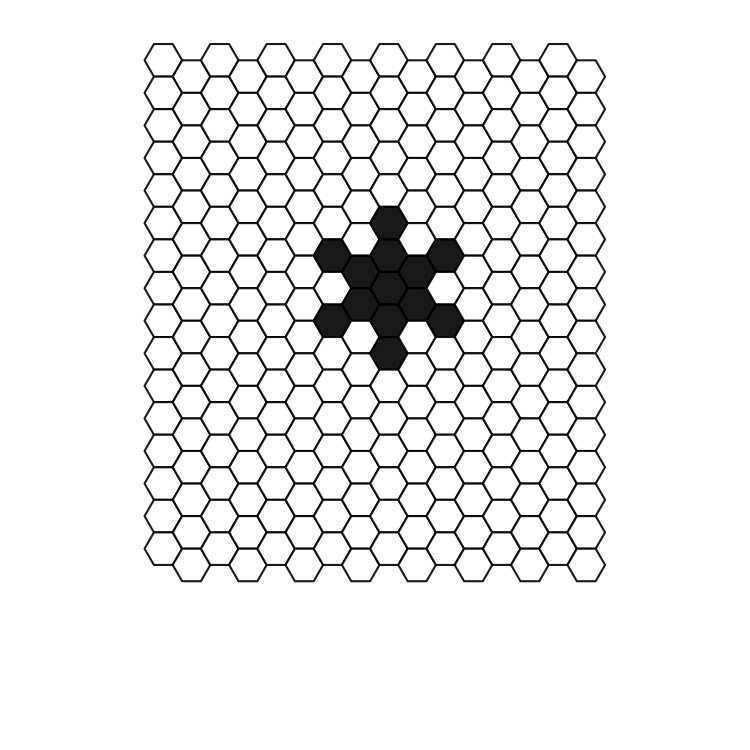

<IPython.core.display.Javascript object>


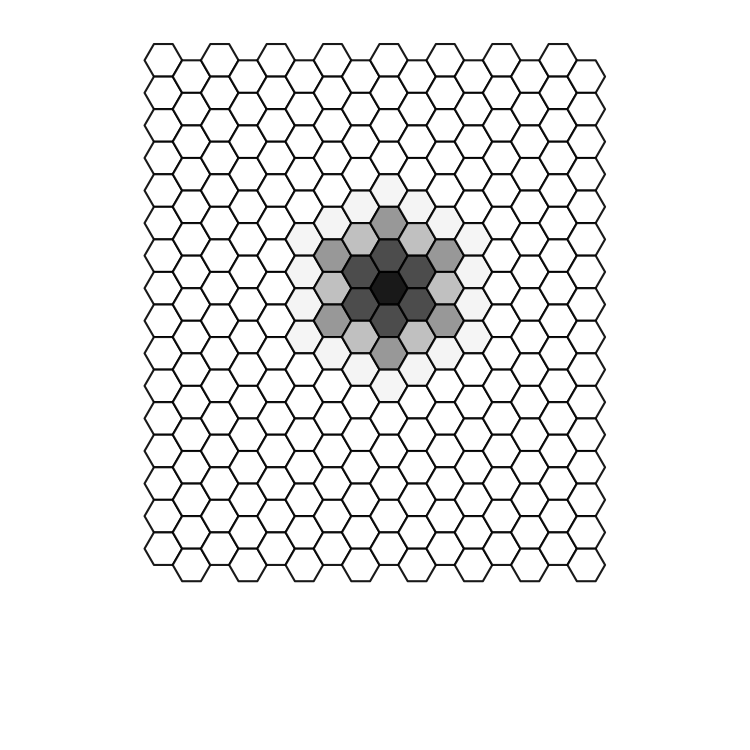

In [6]:
from hexagdly_tools import plot_hextensor
from example_utils import toy_data

'''
example image
'''
# Tensor parameters:
batch_size = 1
channels = 1
num_rows = 16
num_columns = 16

# Place shape in tensor at position (px, py)
image = toy_data('snowflake_2', num_rows, num_columns, channels, batch_size, px=8, py=7)
testimage = image.to_torch_tensor()
plot_hextensor(testimage, image_range=(0,None), channel_range=(0,None), figname='test_image')

'''
smoothed image
'''
sigma = 1 # standard deviation for Gaussian smoothing
smooth = Gauss_Smoothing(sigma)
smoothedimage = smooth(testimage)
plot_hextensor(smoothedimage, image_range=(0,None), channel_range=(0,None), figname='smoothed_image')